In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [2]:
cd zippedData/

/Users/josephmchugh/code/flatiron-project-1/zippedData


In [3]:
#importing datasets
movie_gross = pd.read_csv('bom.movie_gross.csv.gz')
name_basics = pd.read_csv('imdb.name.basics.csv.gz')
title_akas = pd.read_csv('imdb.title.akas.csv.gz')
title_basics = pd.read_csv('imdb.title.basics.csv.gz')
title_crew = pd.read_csv('imdb.title.crew.csv.gz')
title_principles = pd.read_csv('imdb.title.principals.csv.gz')
title_ratings = pd.read_csv('imdb.title.ratings.csv.gz')
rt_movie_info = pd.read_csv('rt.movie_info.tsv.gz', sep='\t')
rt_reviews = pd.read_csv('rt.reviews.tsv.gz', sep='\t', encoding = 'unicode_escape')
tmdb_movies = pd.read_csv('tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('tn.movie_budgets.csv.gz')

In [4]:
#creating main dataframe
main_df = pd.DataFrame(movie_budgets['movie'])

In [5]:
#populating main dataframe from 'movie_budgets' dataset
main_df['Production Budget'] = movie_budgets['production_budget']
main_df['Domestic Gross'] = movie_budgets['domestic_gross']
main_df['Worldwide Gross'] = movie_budgets['worldwide_gross']

In [6]:
#renaming columns
main_df = main_df.rename(columns={'movie':'Title'})
title_basics = title_basics.rename(columns={'primary_title': 'Title'})

In [7]:
#merging 'title_baiscs' dataset with main dataframe
main_df = pd.merge(main_df, title_basics, how='outer', on='Title')

In [8]:
#trimming size of dataframe to first 5782 rows (number of rows with financial data)
main_df = main_df.head(5782)

In [9]:
#dropping uneccessary columns
main_df = main_df.drop(columns = ['tconst','original_title','start_year'])

In [10]:
#dropping null values from 'genres column'
main_df = main_df.dropna(subset=['genres'])

In [11]:
#resetting the index
main_df = main_df.reset_index()

In [12]:
#dropping old index 
main_df = main_df.drop(columns = ['index'])

In [13]:
#removing '$' and ',' from financial data
main_df["Production Budget"] = main_df["Production Budget"].apply(lambda x: x.strip("$"))
main_df["Production Budget"] = main_df["Production Budget"].apply(lambda x: x.replace(",",""))
main_df["Domestic Gross"] = main_df["Domestic Gross"].apply(lambda x: x.strip("$"))
main_df["Domestic Gross"] = main_df["Domestic Gross"].apply(lambda x: x.replace(",",""))
main_df["Worldwide Gross"] = main_df["Worldwide Gross"].apply(lambda x: x.strip("$"))
main_df["Worldwide Gross"] = main_df["Worldwide Gross"].apply(lambda x: x.replace(",",""))

In [14]:
#converting financial data to type(int)
main_df["Production Budget"] = main_df["Production Budget"].astype(int)
main_df["Domestic Gross"] = main_df["Domestic Gross"].astype(int)
main_df["Worldwide Gross"] = main_df["Worldwide Gross"].astype(int)

In [15]:
#correcting Avatar runtime & genre
main_df.loc[(main_df['Title'] == 'Avatar'), ['runtime_minutes']] = 162
main_df.loc[(main_df['Title'] == 'Avatar'), ['genres']] = 'Action, Adventure, Sci-Fi'

In [16]:
main_df["Profit"] = main_df["Worldwide Gross"] - main_df["Production Budget"] 

In [17]:
#Adding commas to numbers for clarity
# main_df['Production Budget'] = main_df['Production Budget'].apply(lambda x: format(x, '8,d'))
# main_df['Domestic Gross'] = main_df['Domestic Gross'].apply(lambda x: format(x, '8,d'))
# # main_df['Worldwide Gross'] = main_df['Worldwide Gross'].apply(lambda x: format(x, '8,d'))
# main_df['Profit'] = main_df['Profit'].apply(lambda x: format(x, '8,d'))

In [18]:
#removing title duplicates
main_df = main_df.drop_duplicates(subset="Title", keep="first")

In [19]:
#ascertaining number of unique genres
main_df["genres"].nunique() 

274

In [20]:
main_df = main_df.sort_values(by=['Profit'], ascending = False)

In [21]:
freq_genres = main_df['genres'].value_counts()
freq_genres_list = list(freq_genres.head(12).keys())

In [22]:
main_df_genres = []
for n in freq_genres_list:
    main_df_genres.append(main_df.loc[(main_df['genres'] == n)])

In [23]:
main_df_genres = pd.concat(main_df_genres)

In [24]:
genres_profit = main_df_genres.groupby(main_df['genres']).mean()

In [25]:
genres_profit = genres_profit.sort_values(by='Profit',ascending=False)

In [26]:
main_df = main_df.dropna(subset=['runtime_minutes'])

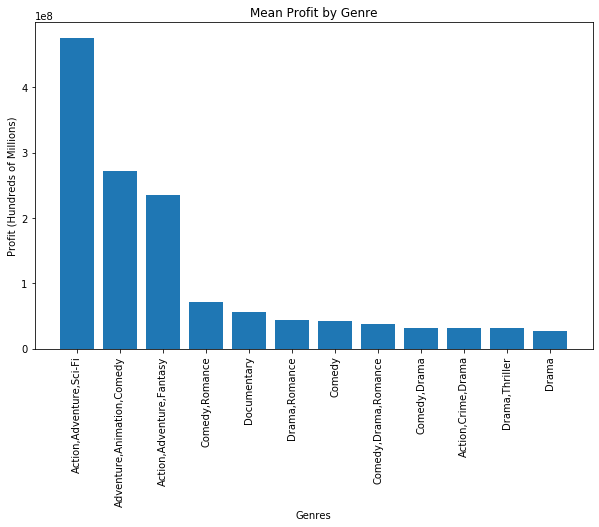

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

x = genres_profit.index
y = genres_profit['Profit']

fig = plt.figure(figsize=(10, 6))
ax = plt.subplot()

plt.bar(x,y)

ax.set_xticks(range(len(x)))
ax.set_xticklabels(x)
plt.xticks(rotation=90)
plt.title('Mean Profit by Genre')
plt.xlabel('Genres')
plt.ylabel('Profit (Hundreds of Millions)')
plt.show()

In [28]:
act_adv_sci = main_df.loc[(main_df['genres'] == 'Action,Adventure,Sci-Fi'),['Title','Production Budget','Domestic Gross','Worldwide Gross','runtime_minutes','Profit']]

In [29]:
act_adv_sci = act_adv_sci.reset_index()
act_adv_sci = act_adv_sci.drop(columns=['index'])

In [30]:
act_adv_sci = act_adv_sci.sort_values(by = 'Profit', ascending = True)

In [31]:
import math

def mean_normalize(var):
    norm = []
    mean = sum(var)/len(var)
    for i in var:
        diff = i - mean
        norm.append(diff)
    return norm

def dot_product(x, y):

    prod_vec = 0 
    for i in range(len(x)):
        prod = x[i]* y[i]
        prod_vec += prod
    return prod_vec

def correlation(var1, var2):
    if len(var1) != len(var2):
        return 'The lengths of both the lists should be equal.' 
    else: 
        mean_norm_var1 = mean_normalize(var1)
        mean_norm_var2 = mean_normalize(var2)
        var1_dot_var2 = dot_product(mean_norm_var1, mean_norm_var2)
        var1_squared = [i * i for i in mean_norm_var1]
        var2_squared = [i * i for i in mean_norm_var2]
    return round(var1_dot_var2 / math.sqrt(sum(var1_squared) * sum(var2_squared)), 2)

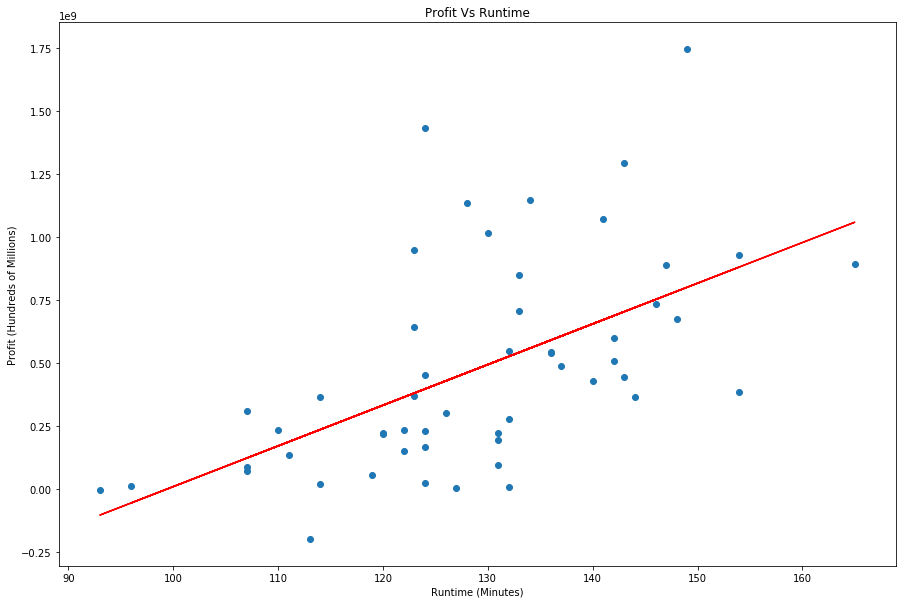

0.57

In [46]:
import numpy as np
from statistics import mean
import numpy as np

xs = np.array(act_adv_sci['runtime_minutes'], dtype=np.float64)
ys = np.array((act_adv_sci['Profit']), dtype=np.float64)

def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    b = mean(ys) - m*mean(xs)
    return m, b

m, b = best_fit_slope_and_intercept(xs,ys)
regression_line = [(m*x)+b for x in xs]

x = act_adv_sci['runtime_minutes']
y = (act_adv_sci['Profit'])
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot()
plt.plot(xs,regression_line, 'r')
# Plot
plt.scatter(x, y)
plt.title('Profit Vs Runtime')
plt.xlabel('Runtime (Minutes)')
plt.ylabel('Profit (Hundreds of Millions)')
plt.show()
correlation(x,y)

In [ ]:
xs = np.array(act_adv_sci['Production Budget'], dtype=np.float64)
ys = np.array(act_adv_sci['Worldwide Gross'], dtype=np.float64)

m, b = best_fit_slope_and_intercept(xs,ys)
regression_line = [(m*x)+b for x in xs]

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot()
plt.plot(xs,regression_line, 'r') 
ax.set_title('Production Budget Vs Worldwide Gross')
ax.set_xlabel('Production Budget (Tens of Millions)')
ax.set_ylabel('Worldwide Gross (Hundreds of Millions)')
 
x = act_adv_sci['Production Budget']
y = act_adv_sci['Worldwide Gross']
 
ax.scatter(x, y)
plt.show()
correlation(x,y)

In [ ]:
xs = np.array(act_adv_sci['Production Budget'], dtype=np.float64)
ys = np.array(act_adv_sci['Profit'], dtype=np.float64)

m, b = best_fit_slope_and_intercept(xs,ys)
regression_line = [(m*x)+b for x in xs]

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot()
plt.plot(xs,regression_line, 'r') 
ax.set_title('Production Budget Vs Profit')
ax.set_xlabel('Production Budget (Tens of Millions)')
ax.set_ylabel('Profit (Hundreds of Millions)')
 
x = act_adv_sci['Production Budget']
y = act_adv_sci['Profit']
 
ax.scatter(x, y)
plt.show()
correlation(x,y)